In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g

In [2]:
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [3]:
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [4]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])
            fb[i][1][0]+=a*(z-ref)+b*(z-ref)**2

        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

The formula for the gradient is stated in Pople's article (Eq.21) as: 
$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [5]:
print(inspect.getsource(g.kernel))
print(inspect.getsource(g.grad_elec))
print(inspect.getsource(g.hcore_generator))

    def kernel(self, mo_energy=None, mo_coeff=None, mo_occ=None, atmlst=None):
        cput0 = (time.clock(), time.time())
        if mo_energy is None: mo_energy = self.base.mo_energy
        if mo_coeff is None: mo_coeff = self.base.mo_coeff
        if mo_occ is None: mo_occ = self.base.mo_occ
        if atmlst is None:
            atmlst = self.atmlst
        else:
            self.atmlst = atmlst

        if self.verbose >= logger.WARN:
            self.check_sanity()
        if self.verbose >= logger.INFO:
            self.dump_flags()

        de = self.grad_elec(mo_energy, mo_coeff, mo_occ, atmlst)
        self.de = de + self.grad_nuc(atmlst=atmlst)
        if self.mol.symmetry:
            self.de = self.symmetrize(self.de, atmlst)
        logger.timer(self, 'SCF gradients', *cput0)
        self._finalize()
        return self.de

def grad_elec(mf_grad, mo_energy=None, mo_coeff=None, mo_occ=None, atmlst=None):
    '''
    Electronic part of RHF/RKS gradients

    Args:
        

In [6]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]))
mf=scf.RHF(nn)
e_nn=mf.scf()

converged SCF energy = -108.916591616523


In [7]:
S=mf.get_ovlp()
h1=mf.get_hcore()
P=mf.make_rdm1()
C=mf.mo_coeff
O=mf.mo_occ
e=mf.mo_energy

In [8]:
g_ijkl=nn.intor("int2e_sph")

In [9]:
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]),charge=-1)
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("pcX-1",fmt="nwchem",elements=[6,7,8]),charge=1)

In [10]:
mf_on=scf.RHF(on)
mf_cn=scf.RHF(cn)
e_on=mf_on.scf()
e_cn=mf_cn.scf()

converged SCF energy = -128.874363294639
converged SCF energy = -92.2576688695164


In [11]:
dS=(on.get_ovlp()-cn.get_ovlp())/2
dh1=(on.get_hcore()-cn.get_hcore())/2
dG=(on.intor("int2e_sph")-cn.intor("int2e_sph"))/2
dVnn=(8*7-7*7)/2.05

converged SCF energy = -128.874363294639
converged SCF energy = -92.2576688695164
converged SCF energy = -128.874363294639
converged SCF energy = -92.2576688695164


In [12]:
print(inspect.getsource(mf.Gradients().make_rdm1e))

    def make_rdm1e(self, mo_energy=None, mo_coeff=None, mo_occ=None):
        if mo_energy is None: mo_energy = self.base.mo_energy
        if mo_coeff is None: mo_coeff = self.base.mo_coeff
        if mo_occ is None: mo_occ = self.base.mo_occ
        return make_rdm1e(mo_energy, mo_coeff, mo_occ)



In [13]:
#from np.grad.rhf   , makes w
def make_rdm1e(mo_energy, mo_coeff, mo_occ):
    '''Energy weighted density matrix'''
    mo0 = mo_coeff[:,mo_occ>0]
    mo0e = mo0 * (mo_energy[mo_occ>0] * mo_occ[mo_occ>0])
    return np.dot(mo0e, mo0.T.conj())

In [14]:
W=make_rdm1e(e,C,O)

$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [15]:
np.einsum("ij,ij",P,dh1),0.5*np.einsum("ij,kl,ijkl",P,P,dG) ,dVnn,-np.einsum("ij,ij",W,dS)

(-23.649717805620124,
 2.7937447765495427,
 3.414634146341464,
 -0.06667508592366489)

In [16]:
e_nn,np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG) +dVnn-np.einsum("ij,ij",W,dS),\
e_nn+np.einsum("ij,ij",P,dh1)+0.5*np.einsum("ij,kl,ijkl",P,P,dG) +dVnn-np.einsum("ij,ij",W,dS)

(-108.91659161652328, -17.508013968652786, -126.42460558517605)

In [17]:
e_nn-np.einsum("ij,ij",P,dh1)-0.5*np.einsum("ij,kl,ijkl",P,P,dG) -dVnn+np.einsum("ij,ij",W,dS)

-91.4085776478705

In [18]:
e_on,e_cn

(-128.87436329463887, -92.25766886951644)

In [45]:
def E_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e
def P_cn(l):
    mol_l=FcM(fcs=[l,0],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7+l,ref=7),"N2":pcX(7)},verbose=1)
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    p=mf_l.make_rdm1()
    return p

For the second alchemical derivative we need at first the response matrix

In [20]:
#The old code for nbs derivs
def alchemy_pol_deriv(polobj,dL, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]

    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords) / charges.sum()
    
    int_r=DeltaV(mol,dL)    ########   .001 as finite difference intervall  
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = np.zeros_like(h1)
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    if with_cphf:
        mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1, s1, polobj.max_cycle_cphf, polobj.conv_tol)
    else:
        mo1 = rhf_nmr._solve_mo1_uncoupled(mo_energy, mo_occ, h1, s1)[0]
    return mo1,e1[0]

In [60]:
#attempt to o this for luck
from pyscf.scf import cphf
vind = mf.Polarizability().gen_vind(mf, C, O)
mo1,e1 = cphf.solve(vind, e, O, -dh1[:,:7], dS[:,:7], 20 ,1e-5)

In [61]:
mo1.shape,e1.shape

((48, 7), (7, 7))

In [62]:
def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

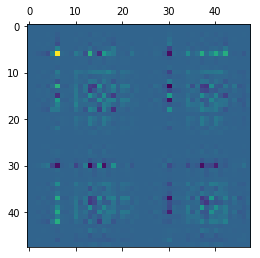

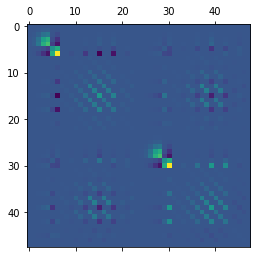

In [63]:
dP=make_dP(mf,mo1)
plt.matshow(dP)
plt.matshow(P)

In [64]:
P+dP*.001

array([[ 4.34477358e-05,  3.24704046e-04,  1.48415973e-03, ...,
        -1.03617098e-04,  6.29733971e-09, -6.48014485e-10],
       [ 3.24704046e-04,  2.42667741e-03,  1.10919244e-02, ...,
        -7.72968899e-04,  1.48357568e-07, -5.00800747e-09],
       [ 1.48415973e-03,  1.10919244e-02,  5.07069905e-02, ...,
        -3.66286153e-03,  8.48333893e-07, -2.32575362e-08],
       ...,
       [-1.03617098e-04, -7.72968899e-04, -3.66286153e-03, ...,
         3.80405808e-03,  3.60629850e-06, -3.69562788e-08],
       [ 6.29733971e-09,  1.48357568e-07,  8.48333893e-07, ...,
         3.60629850e-06,  4.37974838e-03, -9.96985392e-07],
       [-6.48014485e-10, -5.00800747e-09, -2.32575362e-08, ...,
        -3.69562788e-08, -9.96985392e-07, -7.45312072e-20]])

In [72]:
from numpy.linalg import norm
norm(P_cn(-1)-(P+dP))

1.408703185759104

In [79]:
P@S@P-2*P

array([[ 5.42101086e-20,  3.25260652e-19,  4.33680869e-19, ...,
         0.00000000e+00, -5.39781823e-21,  9.02779661e-35],
       [ 3.25260652e-19,  8.67361738e-19,  6.93889390e-18, ...,
         4.33680869e-19, -4.22235508e-20,  8.54631413e-34],
       [ 2.16840434e-18,  1.38777878e-17,  8.32667268e-17, ...,
        -1.73472348e-18, -1.75395012e-19,  4.62223187e-33],
       ...,
       [-2.71050543e-20, -4.33680869e-19, -1.73472348e-18, ...,
         1.73472348e-18, -5.20392189e-19,  2.46519033e-32],
       [-5.39781823e-21, -4.22235508e-20, -1.75395012e-19, ...,
        -5.20392189e-19,  0.00000000e+00,  2.95822839e-31],
       [ 1.08333559e-34,  8.54631413e-34,  2.60000542e-33, ...,
         2.77333912e-32,  3.20474743e-31, -5.60519386e-45]])

In [85]:
norm((P+dP)@S@(P+dP)-2*(P+dP))

1.3143264854188565

In [70]:
norm(P_cn(-1)-(P))

1.2481929404648695

In [ ]:
# FOR HESSIAN CALCULATIONS 
# if mo1 is None or mo_e1 is None:
#         mo1, mo_e1 = hessobj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,
#                                        None, atmlst, max_memory, log)
"""
def solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,
              fx=None, atmlst=None, max_memory=4000, verbose=None):
    '''Solve the first order equation

    Kwargs:
        fx : function(dm_mo) => v1_mo
            A function to generate the induced potential.
            See also the function gen_vind.
    '''
    mol = mf.mol
    if atmlst is None: atmlst = range(mol.natm)

    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]

    if fx is None:
        fx = gen_vind(mf, mo_coeff, mo_occ)
    s1a = -mol.intor('int1e_ipovlp', comp=3)

    def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])

    mem_now = lib.current_memory()[0]
    max_memory = max(2000, max_memory*.9-mem_now)
    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))
    mo1s = [None] * mol.natm
    e1s = [None] * mol.natm
    aoslices = mol.aoslice_by_atom()
    for ia0, ia1 in lib.prange(0, len(atmlst), blksize):
        s1vo = []
        h1vo = []
        for i0 in range(ia0, ia1):
            ia = atmlst[i0]
            shl0, shl1, p0, p1 = aoslices[ia]
            s1ao = numpy.zeros((3,nao,nao))
            s1ao[:,p0:p1] += s1a[:,p0:p1]
            s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)
            s1vo.append(_ao2mo(s1ao))
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_f1ao/%d' % ia
                h1ao = lib.chkfile.load(h1ao_or_chkfile, key)
            else:
                h1ao = h1ao_or_chkfile[ia]
            h1vo.append(_ao2mo(h1ao))

        h1vo = numpy.vstack(h1vo)
        s1vo = numpy.vstack(s1vo)
        mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, h1vo, s1vo)
        mo1 = numpy.einsum('pq,xqi->xpi', mo_coeff, mo1).reshape(-1,3,nao,nocc)
        e1 = e1.reshape(-1,3,nocc,nocc)

        for k in range(ia1-ia0):
            ia = atmlst[k+ia0]
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_mo1/%d' % ia
                lib.chkfile.save(h1ao_or_chkfile, key, mo1[k])
            else:
                mo1s[ia] = mo1[k]
            e1s[ia] = e1[k].reshape(3,nocc,nocc)
        mo1 = e1 = None

    if isinstance(h1ao_or_chkfile, str):
        return h1ao_or_chkfile, e1s
    else:
        return mo1s, e1s

"""